In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
file_path = "pca_reduced_dataset.csv"  
df = pd.read_csv(file_path)

# Separate features (X) and target labels (y)
X = df.iloc[:, :-1].values  # All PCA features (PC1 to PC148)
y = df.iloc[:, -1].values   # Target column

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for 1D CNN (samples, time steps, channels)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Print final dataset shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (742, 148, 1), X_test shape: (186, 148, 1)
y_train shape: (742,), y_test shape: (186,)


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the 1D CNN model
model = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=5, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape=(148, 1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=5, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Strong dropout to prevent overfitting
    layers.Dense(len(np.unique(y)), activation="softmax")  # Multi-class classification
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


C:\Users\sihus\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 144, 64)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 144, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 144, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 72, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 68, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 68, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 68, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 34, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 32, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,756 (2.54 MB)

 Trainable params: 665,860 (2.54 MB)

 Non-trainable params: 896 (3.50 KB)

In [29]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Reduce learning rate if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [31]:
# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4778 - loss: 7.0029 - val_accuracy: 0.3978 - val_loss: 6.5985 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6438 - loss: 5.7596 - val_accuracy: 0.2688 - val_loss: 8.9771 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6704 - loss: 5.3760 - val_accuracy: 0.2688 - val_loss: 10.7376 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7654 - loss: 4.9133 - val_accuracy: 0.2688 - val_loss: 11.7887 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7629 - loss: 4.5582 - val_accuracy: 0.2688 - val_loss: 11.7171 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8056 - loss: 4.2504 - val_accuracy: 0.2688 - val_loss: 12.5103 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8382 - loss: 3.965

In [33]:
# Evaluate performance on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9033 - loss: 0.8621 
Test Accuracy: 88.71%


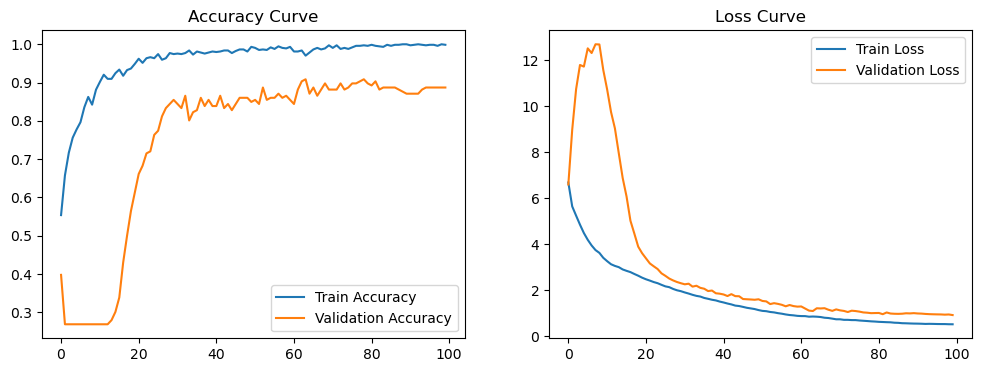

In [37]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()


In [39]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert numerical predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_test)

# Display Classification Report
print(classification_report(y_true_labels, y_pred_labels))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        51
           1       1.00      1.00      1.00        50
           2       0.83      0.96      0.89        52
           3       0.75      0.82      0.78        33

    accuracy                           0.89       186
   macro avg       0.88      0.88      0.88       186
weighted avg       0.90      0.89      0.89       186



In [75]:
import numpy as np

# Select a random index from the test set
random_index = np.random.randint(0, len(X_test))

# Extract the actual sample and its true label
actual_sample = X_test[random_index]
actual_label = y_test[random_index] 

actual_sample = np.expand_dims(actual_sample, axis=0)

# Make a prediction
prediction = model.predict(actual_sample)
predicted_class = np.argmax(prediction)

actual_label_text = label_encoder.inverse_transform([actual_label])
predicted_label_text = label_encoder.inverse_transform([predicted_class])

# Print results
print(f"Actual Class: {actual_label_text[0]}")
print(f"Predicted Class: {predicted_label_text[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Class: 2
Predicted Class: 2
